# Train a Random Forest Model
Documentation: [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### Import, split data

In [28]:
# import explainer
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime

start = datetime.datetime.now()
print('Began at ', start)

df = pd.read_csv('data.csv')
y = df['METHUSE']
X = df.drop(columns='METHUSE')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.07, test_size=0.03, random_state=24)

Began at  2022-06-17 21:07:39.465743


In [29]:
print(len(X), len(X_train), len(X_test))

522964 36607 15689


### Randomly search parameter grid for best model

In [30]:
# Build grid of parameters for random search
#     Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

# Number of trees in random forest
n_estimators = [i for i in range(100, 1100, 100)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [j for j in range(10, 110, 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [4, 6, 8, 10, 12, 14, 16]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               # 'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print('There are 10x3x10x7x4 = 8,400 possible parameter combinations.\n')
pprint(random_grid)

There are 10x3x10x7x4 = 8,400 possible parameter combinations.

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [2, 4, 6, 8],
 'min_samples_split': [4, 6, 8, 10, 12, 14, 16],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [31]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using cross validation and all available cores (n_jobs=-1)
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions = random_grid, 
                               n_iter=1,
                               # n_iter=1000,
                               cv=2,
                               verbose=2, 
                               random_state=24, 
                               n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=1,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'min_samples_leaf': [2, 4, 6, 8],
                                        'min_samples_split': [4, 6, 8, 10, 12,
                                                              14, 16],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=24, verbose=2)

In [32]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 16,
 'min_samples_leaf': 4,
 'max_depth': 20}

In [33]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=16,
                       n_estimators=900)

In [34]:
# Evaluate random method
from sklearn.metrics import mean_squared_error

base_model = rf_random.best_estimator_
base_model.fit(X_train, y_train)
y_hat = base_model.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print('MSE:', mse)

MSE: 0.16438268850787174


## Search around best random model for overall best model  

In [35]:
# stop

In [36]:
# # Create the parameter grid based on the results of random search
# from sklearn.model_selection import GridSearchCV
#
# param_grid = {
#     'max_depth': [80, 90, 100],
#     'max_features': ['auto'],
#     'min_samples_leaf': [1,2,4],
#     'min_samples_split': [2,4,6],
#     'n_estimators': [700, 800, 900]
#     }
# # print('There are 3x1x3x3x3 = 81 possible parameter combinations.')
#
# # param_grid = {
# #     'bootstrap': [True],
# #     'max_depth': [100],
# #     'max_features': ['auto'],
# #     'min_samples_leaf': [4],
# #     'min_samples_split': [8],
# #     'n_estimators': [1400]
# #     }
#
# # Create a base model
# rf = RandomForestClassifier(random_state=24)
#
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [37]:
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

In [38]:
# grid_search.best_params_

In [39]:
# # Evaluate best model
# from sklearn.metrics import mean_squared_error
#
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)
# y_hat = best_model.predict(X_test)
#
# mse = mean_squared_error(y_test, y_hat)
#
# print('MSE:', mse)
#
# # Show parameters of best overall model
# best_model

## Interpret best model
Best documentation: [https://christophm.github.io/interpretable-ml-book/shap.html](https://christophm.github.io/interpretable-ml-book/shap.html)

In [40]:
# Define functions for interpretation

from sklearn.base import clone
import datetime

def absolute_share(input_list):
    absolute_list = [abs(i) for i in input_list]
    absolute_share_list = [j/sum(absolute_list) for j in absolute_list]
    return absolute_share_list

In [41]:
best_model = base_model # FOR TESTING ONLY

In [42]:
from sklearn.inspection import permutation_importance
import shap, datetime

imp = pd.DataFrame()
imp['variables'] = X_train.columns

# Add feature importance based on Shapley method
#     https://github.com/slundberg/shap
print('Began Shapley at', datetime.datetime.now())
# explainer = shap.TreeExplainer(best_model)
explainer = shap.TreeExplainer(best_model)

Began Shapley at 2022-06-17 21:11:31.705657


In [43]:
X_test_subset = X_test.sample(100, random_state=24)
shap_values = explainer.shap_values(X_test_subset, approximate=True)[0]   # Remove "approximate=True" when running for real

In [44]:
df = pd.DataFrame(shap_values, columns=X_test.columns)
mean_shapley = [df[col].mean() for col in df.columns]
imp['shapley'] = mean_shapley
imp['shapley_abs'] = absolute_share(mean_shapley)

In [45]:
imp.sort_values('shapley', ascending=False).to_csv('shapley_test.csv', index=False)

In [46]:
y_test.mean()

0.40544330422589075

In [47]:
shap.initjs()

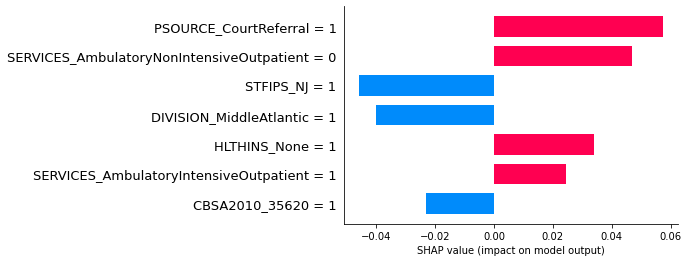

In [48]:
shap.bar_plot(shap_values=shap_values[0,:], features=X_test_subset.iloc[0,:])

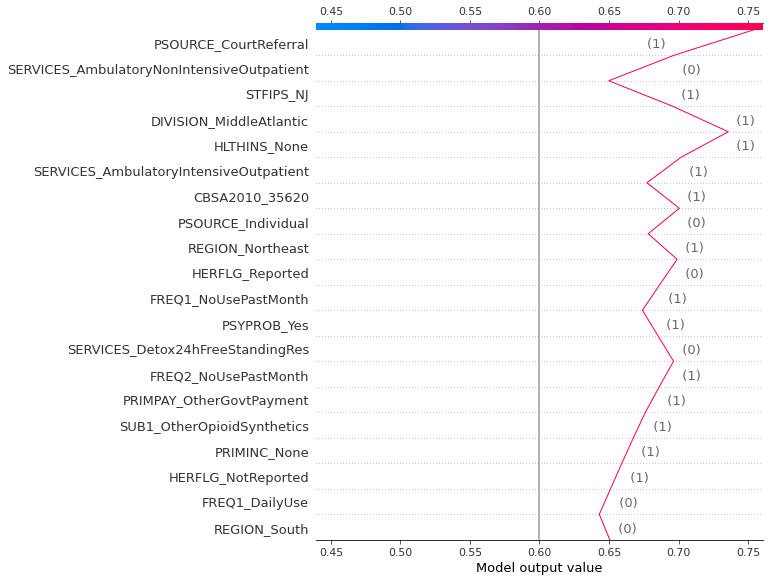

In [49]:
# Decision plot for single sample
shap.decision_plot(explainer.expected_value[0], shap_values[0,:], X_test_subset.iloc[0,:])

In [50]:
# shap.waterfall_plot(shap_values[0])
# shap.text_plot(shap_values[0])
# TODO review fairness: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.group_difference_plot.html

In [51]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0,:], X_test_subset.iloc[0,:])

In [52]:
# # create a dependence plot to show the effect of a single feature across the whole dataset
# shap.dependence_plot(0, shap_values, X_test)

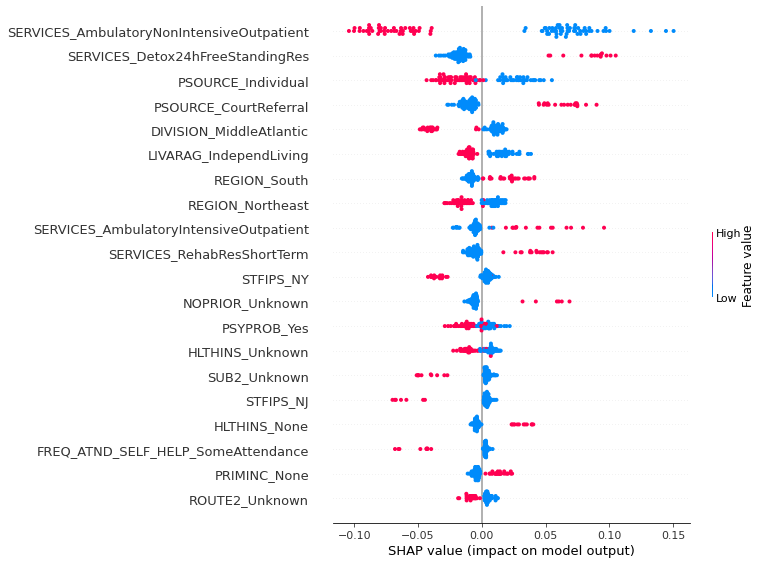

In [53]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test_subset)

In [54]:
# Reveal the sign of the feature importance
len(shap_values)

100

In [55]:
import os
os.system('say "Daisy, daisy, give me your answer true,, I am,  half, crazy, all for the love of you"')

end = datetime.datetime.now()
print(end - start)

0:04:03.914164
